# Customising alignment layout

Lakeview is built upon [Matplotlib](https://matplotlib.org/) and inherits its incredible capacity for customizations. This tutorial demonstrates various ways to customise the output plot based on the same input data, which is typically achieved by passing optional arguments to the plotting function (such as `lakeview.SequenceAlignment.draw_alignment`).


## The default 
Here we show the default output of Lakeview to be contrasted with specific customizations.

In [43]:
import lakeview as lv

# Load aligned segments in a selected region from a BAM file
painter = lv.SequenceAlignment.from_file(
    "../../tests/data/HG002_IGH_PacBio_CCS.bam", region="chr14:105,660,000-105,780,000"
)
# Create an empty GenomeViewer with one track
gv = lv.GenomeViewer(tracks=1, figsize=(8, 5))
# Plot aligned segments
painter.draw_alignment(gv.axes[0])
gv.set_xlim(105_670_000, 105_777_000)

(105670000.0, 105777000.0)

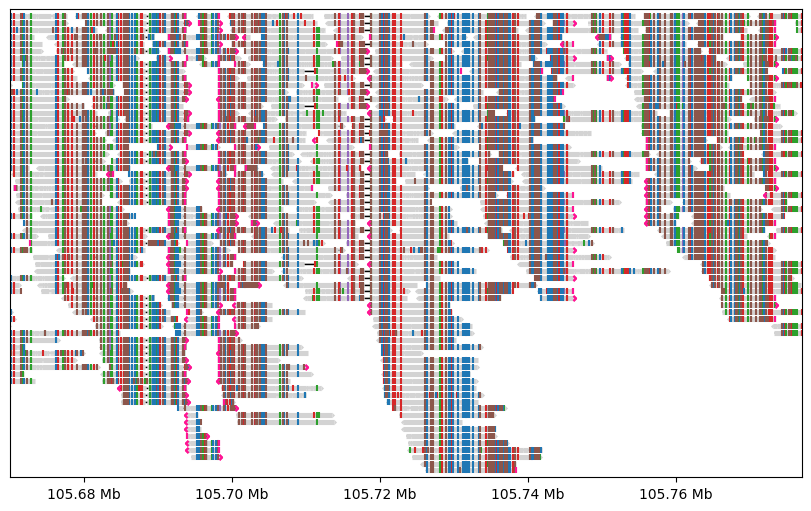

In [44]:
gv.figure

## Showing/hiding specific visual elements

Most visual elements can be toggled on/off using the corresponding parameter starting with "show". For example, if you would like to hide mismatched bases, specify `show_mismatches=False`. 

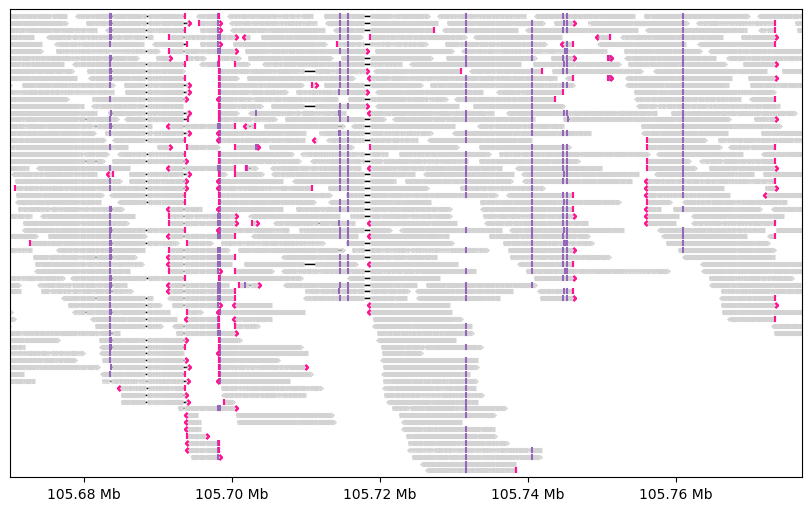

In [2]:
gv = lv.GenomeViewer(tracks=1, figsize=(8, 5))
painter.draw_alignment(gv.axes[0], show_mismatches=False)
gv.set_xlim(105_670_000, 105_777_000)
gv.figure

## Matplotlib keyword arguments

Almost all visual elements drawn by Lakeview can be customised by the corresponding keyword arguments, which will be passed to relevant Matplotlib functions. For example, if you want to show insertion markers in black rather than the default colour purple, you may do that by passing `color="black"` to `insertions_kw`:


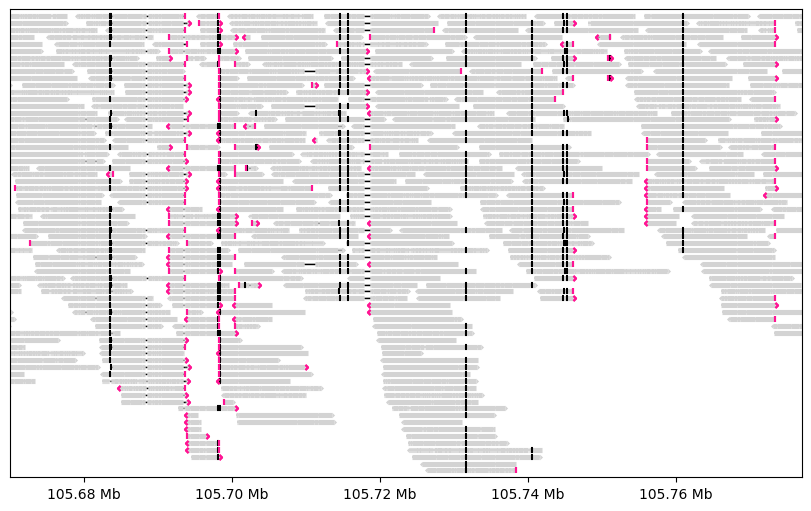

In [3]:
gv = lv.GenomeViewer(tracks=1, figsize=(8, 5))
painter.draw_alignment(gv.axes[0], show_mismatches=False, insertions_kw=dict(color='black'))
gv.set_xlim(105_670_000, 105_777_000)
gv.figure

To find out which keyword parameters are supported for a given element, such as `color`, `linewidth` and `fontsize`, you may need to inspect the [source code](https://github.com/jzhang-dev/lakeview/).

## Data-dependent customization

Often it is desired to arrange the visualization in a way that is not purely cosmetic, but informs certain aspects of the data. For example, a user may wish to link the primary and supplementary alignments of the same query sequence, group sequences by haplotype-specific markers, or highlight pair-end reads with unusual orientations. In Lakeview, this is supported by the use of five parameters, `filter_by`, `sort_by`, `link_by`, `group_by`, `color_by`, each offering an entrance point for data-dependent layout. 

In general, each of the five parameters supports three types of values:

- A `string` literal representing a supported preset. For example, `sort_by="length` sorts all segments by their length (longest first) before plotting.
- An `Iterable` of *n* values, where *n* is the number of aligned segments loaded. For example, if you specify `sort_by=random_numbers`, where `random_numbers` is a `list` of precalculated random numbers of length *n*, then the aligned segments will be shuffled randomly before plotting. 
- A `Callable` that accepts an `AlignedSegment` as the only argument, and returns a value to be used in filtering, sorting, etc. For example, if you specify `group_by=lambda segment: 0 if segment.is_forward else 1`, then segments mapped to the forward and reverse strands will be groupped separately before plotting. 

### `filter_by`

`filter_by` allows you visualize only a subset of segments present in the input BAM base on a custom rule. `filter_by` accepts a `bool` value for each segment and only include the segment if the value is `True`. 

For example, let's remove segments shorter than 15 kb:

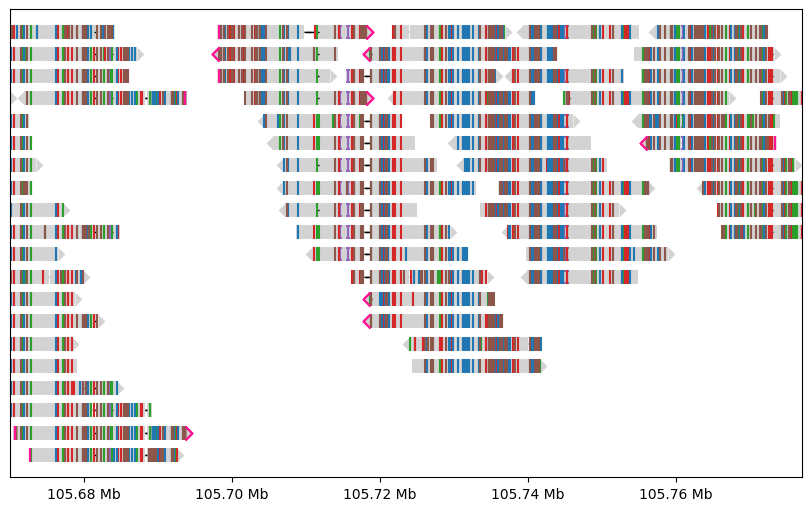

In [18]:
gv = lv.GenomeViewer(tracks=1, figsize=(8, 5))
painter.draw_alignment(gv.axes[0], filter_by=lambda segment: segment.query_alignment_length >= 15e3)
gv.set_xlim(105_670_000, 105_777_000)
gv.figure

### `sort_by` 

`sort_by` accepts a value (most commonly `int`, `float` and `str`) and sort segments based on the corresponding value before plotting. 

For example, let's randomly shuffle the segments:

In [24]:
from numpy.random import default_rng

random_number_generator = default_rng(3920)
random_numbers = [random_number_generator.random() for segment in painter.segments]
random_numbers[:10]

[0.11174910030200058,
 0.38261365584428964,
 0.5984047554571691,
 0.13897640824517798,
 0.260850256514894,
 0.04927694480060274,
 0.7115838426728361,
 0.8585827789629534,
 0.6863772495557511,
 0.21118263555829586]

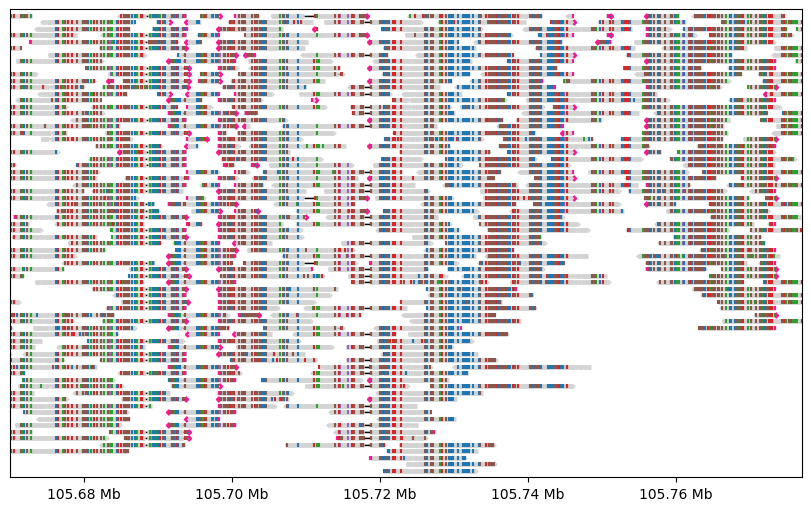

In [25]:
gv = lv.GenomeViewer(tracks=1, figsize=(8, 5))

painter.draw_alignment(gv.axes[0], sort_by=random_numbers)
gv.set_xlim(105_670_000, 105_777_000)
gv.figure

### `link_by`

`link_by` links two or more segments together, drawing them on the same row connected by a horizontal line. `link_by` accepts a "link identifier" (most commonly `int` and `str`) for each segment, and links together segments with the same link identifier. 

For example, let's link together the primary and supplementary alignments of each query sequence, which is equalvalent to linking by the name of the query sequence:

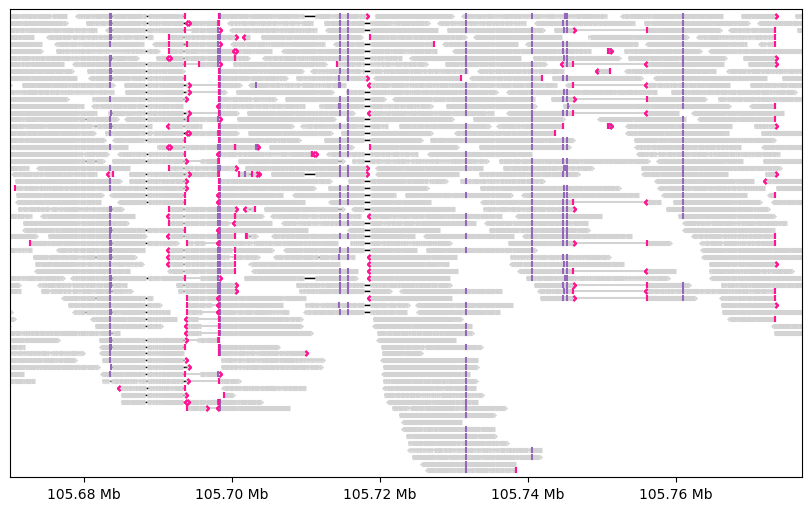

In [32]:
gv = lv.GenomeViewer(tracks=1, figsize=(8, 5))

painter.draw_alignment(gv.axes[0], link_by=lambda segment: segment.query_name, show_mismatches=False)
gv.set_xlim(105_670_000, 105_777_000)
gv.figure

Note the linked segments at around 105.695 Mb and 105.750 Mb.

### `group_by`

`group_by` catgorizes segments into separate groups with optional group labels. `group_by` accepts a "group identifier" (most commonly `int` and `str`) for each segment, and assigns segments with the same group identifier into the same group. 

For example, let's group segments by their orientations:

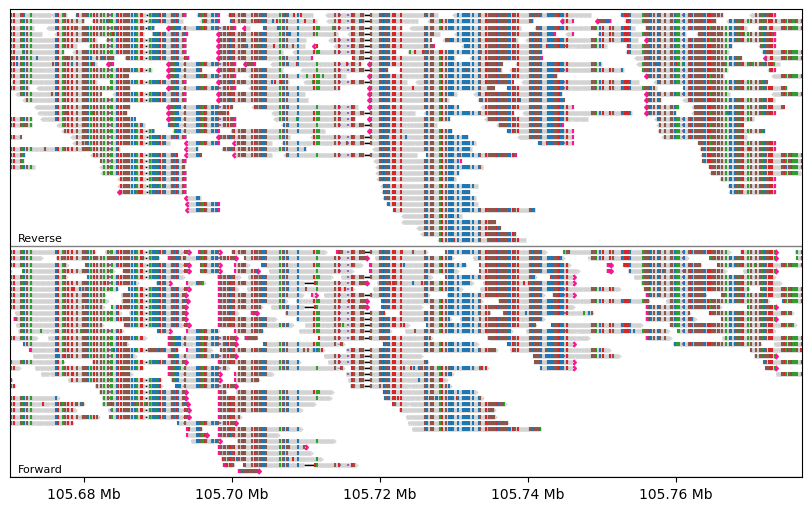

In [35]:
gv = lv.GenomeViewer(tracks=1, figsize=(8, 5))

painter.draw_alignment(
    gv.axes[0],
    group_by=lambda segment: segment.is_forward,
    group_labels={True: "Forward", False: "Reverse"},
)
gv.set_xlim(105_670_000, 105_777_000)
gv.figure


Alternatively, you can use the preset `group_by="strand"`:

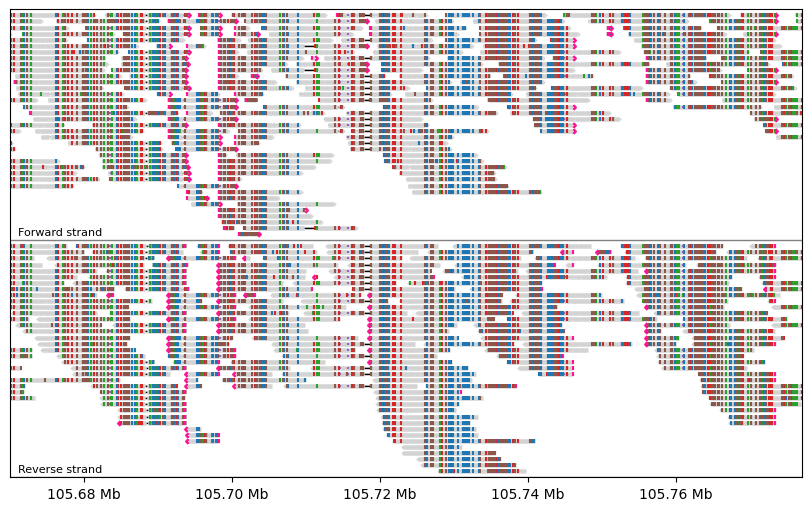

In [36]:
gv = lv.GenomeViewer(tracks=1, figsize=(8, 5))

painter.draw_alignment(gv.axes[0], group_by="strand")
gv.set_xlim(105_670_000, 105_777_000)
gv.figure

### `color_by`

`color_by` allows segments to be colored individually. Each segment is mapped to a [color](https://matplotlib.org/stable/tutorials/colors/colors.html), which defines the color of the segment backbone. 

Let's highlight segments with mapping quality less than 50 with dark red:

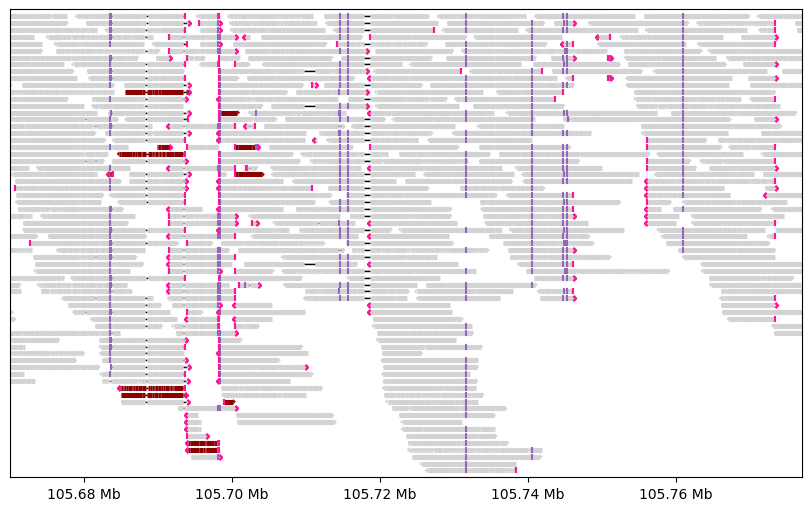

In [42]:
gv = lv.GenomeViewer(tracks=1, figsize=(8, 5))

painter.draw_alignment(
    gv.axes[0],
    color_by=lambda segment: "darkred"
    if segment.mapping_quality < 50
    else "lightgray",
    show_mismatches=False,
)
gv.set_xlim(105_670_000, 105_777_000)
gv.figure
